In [1]:
import tensorflow as tf
import numpy as np
import os
import sys

In [2]:
# Path para importacion de funciones
dir_actual    = os.path.abspath('')
dir_parent = os.path.dirname(dir_actual)
if not dir_parent in sys.path: sys.path.append(dir_parent)

## Loading CIFAR10 Data

In [3]:
(_, _), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
# Normalizando
x_test = x_test/255.
# Reducing Target innecessary dimension
y_test  = np.squeeze(y_test)

## Creating Dataset Objects

In [4]:
from functions import to_categorical, VGG_resize

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.map(to_categorical)
test_dataset = test_dataset.map(VGG_resize)
test_dataset = test_dataset.batch(1)

## Loading Quantized model and Non Quantized model 

En base al resultado del ultimo item del cuaderno "VGG Analysis" las entradas/salidas de las capas tienen valores que varian entre -27 y 44.03, Salvo la ultima capa densa, las activaciones de todas las demas capas estan contenidas en valores bajos (magnitud menor a 5)

In [5]:
from models import VGG16_body

input_layer   = tf.keras.Input((224,224,3))
output_layer  = VGG16_body(input_layer, Quantization = False)

Frac_Bits = 6
Int_Bits  = 5

Qinput_layer  = tf.keras.Input((224,224,3))
Qoutput_layer = VGG16_body(Qinput_layer, Quantization = True, word_size = (Frac_Bits+Int_Bits+1), frac_size = Frac_Bits)

VGG16  = tf.keras.Model(inputs=input_layer, outputs=output_layer)
QVGG16 = tf.keras.Model(inputs=Qinput_layer, outputs=Qoutput_layer)

## Loading Pretrained Weights

In [6]:
# Loading Wieghts
cwd = os.getcwd()
Wgt_dir = os.path.join(cwd,'TrainedWeights')
Wgt_dir = os.path.join(Wgt_dir,'Weights')

VGG16.load_weights(Wgt_dir)
QVGG16.load_weights(Wgt_dir)

## Quantize weights

En base al resultado del ultimo item del cuaderno "VGG Analysis" los pesos valores que varian entre -0.1 y 0.1.

Considerando un bit para el signo, se necesitan al menos 0 bits para la parte entera, se medirá el accuracy de modelos en funcion del numero de bits destinados a la parte fraccionaria.

In [7]:
from models import Weight_Quantization
Weight_Quantization(model = QVGG16, Frac_Bits = 8, Int_Bits = 5)

## Check the general Accuracy

In [8]:
# Optimization params
# -------------------

# Loss
loss = tf.keras.losses.CategoricalCrossentropy()

# learning rate
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Validation metrics
# ------------------

metrics = ['accuracy']
# ------------------

# Compile Model
#VGG16.compile(optimizer=optimizer, loss=loss, metrics=metrics)
QVGG16.compile(optimizer=optimizer, loss=loss, metrics=metrics)

## desempeño del modelo original

In [13]:
VGG16.evaluate(test_dataset)

10000/10000 [==============================] - 143s 14ms/step - loss: 0.8012 - accuracy: 0.7349


[0.8012385264062973, 0.7349]

# Experimento 1: Cuantizacion homogenea, sin saturacion

### 4 bits de precision para pesos && 4 bits de precision para activaciones

In [17]:
QVGG16.evaluate(test_dataset)

10000/10000 [==============================] - 176s 18ms/step - loss: 2.3026 - accuracy: 0.1000


[2.3025851249694824, 0.1]

### 5 bits de precision para pesos && 5 bits de precision para activaciones

In [10]:
QVGG16.evaluate(test_dataset)

10000/10000 [==============================] - 173s 17ms/step - loss: 1.6283 - accuracy: 0.6467


[1.6282763871062547, 0.6467]

### 6 bits de precision para pesos && 6 bits de precision para activaciones

In [15]:
QVGG16.evaluate(test_dataset)

10000/10000 [==============================] - 176s 18ms/step - loss: 1.0620 - accuracy: 0.7302


[1.061964491548948, 0.7302]

5 bits son necesarios para un buen resultado, con 6 se alcanza los resultados del modelo original, con 4 bits o menos es practicamente un clasificador aleatorio

# Experimento 2: Variacion de precision en los pesos, precision fija de activaciones (6 bits), sin saturacion

### 5 bits de precision para los pesos

In [19]:
QVGG16.evaluate(test_dataset)

10000/10000 [==============================] - 192s 19ms/step - loss: 1.3600 - accuracy: 0.6517


[1.359971114255674, 0.6517]

### 4 bits de precision para los pesos

In [24]:
QVGG16.evaluate(test_dataset)

10000/10000 [==============================] - 194s 19ms/step - loss: 2.2877 - accuracy: 0.1683


[2.2877005631923675, 0.1683]

# Experimento 3: Variacion de precision en las activaciones, precision fija de pesos (6 bits), sin saturacion

### 5 bits de precision para las activaciones

In [10]:
QVGG16.evaluate(test_dataset)

10000/10000 [==============================] - 194s 19ms/step - loss: 1.3297 - accuracy: 0.7154


[1.3296991717003286, 0.7154]

### 4 bits de precision para las activaciones

In [15]:
QVGG16.evaluate(test_dataset)

10000/10000 [==============================] - 196s 20ms/step - loss: 2.0214 - accuracy: 0.6696


[2.0214044406071303, 0.6696]

# Experimento 4: Variacion en el numero de bits para la parte entera de las activaciones (precision de 6 bits tanto para pesos como activaciones)

### 5 bits de precision para la parte entera de las activaciones

In [25]:
QVGG16.evaluate(test_dataset)

10000/10000 [==============================] - 193s 19ms/step - loss: 1.0620 - accuracy: 0.7302


[1.061964491548948, 0.7302]

### 4 bits de precision para la parte entera de las activaciones

In [10]:
QVGG16.evaluate(test_dataset)

10000/10000 [==============================] - 198s 20ms/step - loss: 1.0616 - accuracy: 0.7301


[1.0615878112137318, 0.7301]

### 3 bits de precision para la parte entera de las activaciones

In [15]:
QVGG16.evaluate(test_dataset)

10000/10000 [==============================] - 193s 19ms/step - loss: 1.0584 - accuracy: 0.7168


[1.0583813532166182, 0.7168]

### 2 bits de precision para la parte entera de las activaciones

In [20]:
QVGG16.evaluate(test_dataset)

10000/10000 [==============================] - 193s 19ms/step - loss: 1.0659 - accuracy: 0.6122


[1.0659365747720002, 0.6122]

# Experimento 5: Variacion en el numero de bits para la parte fraccionaria de los pesos en capas FC (precision de 6 bits tanto para pesos como activaciones)

### 5 bits de precision para capas FC.

In [25]:
QVGG16.evaluate(test_dataset)

10000/10000 [==============================] - 193s 19ms/step - loss: 1.0716 - accuracy: 0.7229


[1.071614341450669, 0.7229]

# Resumen mejores configuraciones

### Pesos capas no FC: precicion = 6, parte entera = 0.  
### Pesos capas FC: precicion = 5, parte entera = 0.
### Activaciones:    precicion = 5, parte entera = 5.

In [11]:
QVGG16.evaluate(test_dataset)

10000/10000 [==============================] - 194s 19ms/step - loss: 1.3445 - accuracy: 0.7094


[1.3444649095077068, 0.7094]

### Pesos capas no FC: precicion = 6, parte entera = 0.  
### Pesos capas FC: precicion = 5, parte entera = 0.
### Activaciones:    precicion = 6, parte entera = 5.

In [26]:
QVGG16.evaluate(test_dataset)

10000/10000 [==============================] - 193s 19ms/step - loss: 1.0716 - accuracy: 0.7229


[1.071614341450669, 0.7229]

### Pesos capas no FC: precicion = 6, parte entera = 0.  
### Pesos capas FC: precicion = 5, parte entera = 0.
### Activaciones:    precicion = 6, parte entera = 5.

In [21]:
QVGG16.evaluate(test_dataset)

10000/10000 [==============================] - 192s 19ms/step - loss: 1.0620 - accuracy: 0.7302


[1.061964491548948, 0.7302]

## Plotting the results

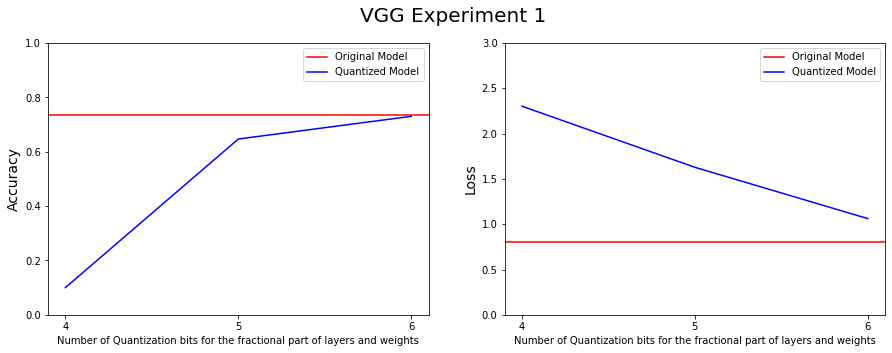

In [9]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2,figsize=(15,5))
fig.suptitle('VGG Experiment 1',fontsize=20)

Acc  = [0.1, 0.6467, 0.7302]
Qbits = [4, 5, 6]

axs[0].set_xticks(Qbits)
axs[0].set_ylim([0, 1])
axs[0].set_xlabel('Number of Quantization bits for the fractional part of layers and weights')
axs[0].set_ylabel('Accuracy',fontsize=14)
axs[0].axhline(y=0.7349, color='r', linestyle='-')
axs[0].plot(Qbits,Acc, color = 'b', linestyle='-')
axs[0].legend(('Original Model','Quantized Model'))

Loss = [2.3025851249694824, 1.6282763871062547, 1.061964491548948]

axs[1].set_xticks(Qbits)
axs[1].set_ylim([0, 3])
axs[1].set_xlabel('Number of Quantization bits for the fractional part of layers and weights')
axs[1].set_ylabel('Loss',fontsize=14)
axs[1].axhline(y=0.8012385272836876, color='r', linestyle='-')
axs[1].plot(Qbits,Loss, color = 'b', linestyle='-')
axs[1].legend(('Original Model','Quantized Model'))

fig.savefig('Figuras/Experimentos_Cuantizacion/VGG16 Quantization Experiment 1.png')

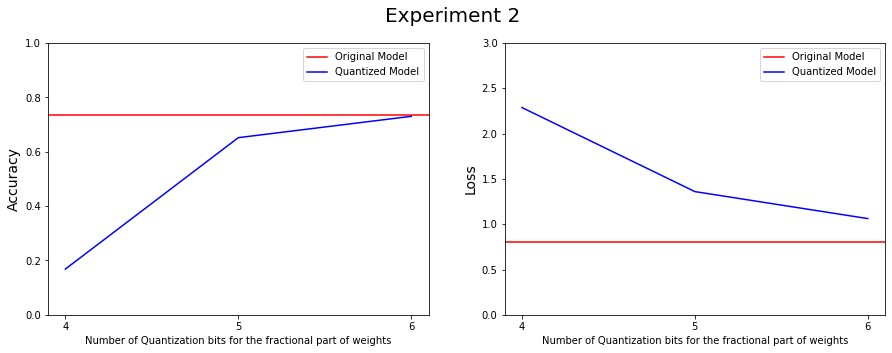

In [10]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
fig.suptitle('Experiment 2',fontsize=20)

Acc  = [0.1683, 0.6517, 0.7302]
Qbits = [4, 5, 6]

axs[0].set_xticks(Qbits)
axs[0].set_ylim([0, 1])
axs[0].set_xlabel('Number of Quantization bits for the fractional part of weights')
axs[0].set_ylabel('Accuracy',fontsize=14)
axs[0].axhline(y=0.7349, color='r', linestyle='-')
axs[0].plot(Qbits,Acc, color = 'b', linestyle='-')
axs[0].legend(('Original Model','Quantized Model'))

Loss = [2.2877005631923675, 1.359971114255674, 1.061964491548948]

axs[1].set_xticks(Qbits)
axs[1].set_ylim([0, 3])
axs[1].set_xlabel('Number of Quantization bits for the fractional part of weights')
axs[1].set_ylabel('Loss',fontsize=14)
axs[1].axhline(y=0.8012385272836876, color='r', linestyle='-')
axs[1].plot(Qbits,Loss, color = 'b', linestyle='-')
axs[1].legend(('Original Model','Quantized Model'))

fig.savefig('Figuras/Experimentos_Cuantizacion/VGG Quantization Experiment 2.png')

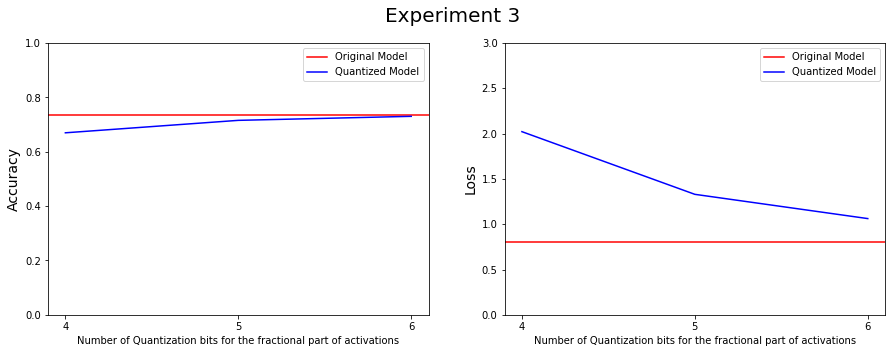

In [11]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
fig.suptitle('Experiment 3',fontsize=20)

Acc  = [0.6696, 0.7154, 0.7302]
Qbits = [4, 5, 6]

axs[0].set_xticks(Qbits)
axs[0].set_ylim([0, 1])
axs[0].set_xlabel('Number of Quantization bits for the fractional part of activations')
axs[0].set_ylabel('Accuracy',fontsize=14)
axs[0].axhline(y=0.7349, color='r', linestyle='-')
axs[0].plot(Qbits,Acc, color = 'b', linestyle='-')
axs[0].legend(('Original Model','Quantized Model'))

Loss = [2.0214044406071303, 1.3296991717003286, 1.061964491548948]

axs[1].set_xticks(Qbits)
axs[1].set_ylim([0, 3])
axs[1].set_xlabel('Number of Quantization bits for the fractional part of activations')
axs[1].set_ylabel('Loss',fontsize=14)
axs[1].axhline(y=0.8012385272836876, color='r', linestyle='-')
axs[1].plot(Qbits,Loss, color = 'b', linestyle='-')
axs[1].legend(('Original Model','Quantized Model'))

fig.savefig('Figuras/Experimentos_Cuantizacion/VGG Quantization Experiment 3.png')

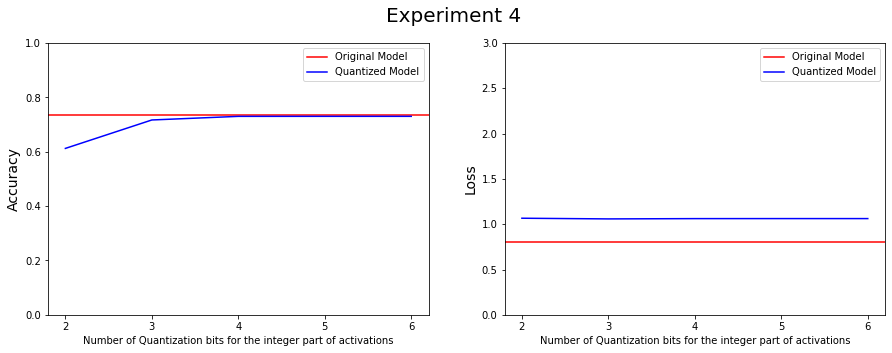

In [12]:
fig, axs = plt.subplots(1,2,figsize=(15,5))
fig.suptitle('Experiment 4',fontsize=20)

Acc  = [0.6122, 0.7168, 0.7301, 0.7302, 0.7302]
Qbits = [2, 3, 4, 5, 6]

axs[0].set_xticks(Qbits)
axs[0].set_ylim([0, 1])
axs[0].set_xlabel('Number of Quantization bits for the integer part of activations')
axs[0].set_ylabel('Accuracy',fontsize=14)
axs[0].axhline(y=0.7349, color='r', linestyle='-')
axs[0].plot(Qbits,Acc, color = 'b', linestyle='-')
axs[0].legend(('Original Model','Quantized Model'))

Loss = [1.0659365747720002, 1.0583813532166182, 1.0615878112137318, 1.061964491548948, 1.061964491548948]

axs[1].set_xticks(Qbits)
axs[1].set_ylim([0, 3])
axs[1].set_xlabel('Number of Quantization bits for the integer part of activations')
axs[1].set_ylabel('Loss',fontsize=14)
axs[1].axhline(y=0.8012385272836876, color='r', linestyle='-')
axs[1].plot(Qbits,Loss, color = 'b', linestyle='-')
axs[1].legend(('Original Model','Quantized Model'))

fig.savefig('Figuras/Experimentos_Cuantizacion/VGG Quantization Experiment 4.png')